# Designing Agents for the Sailing Challenge

In this notebook, we'll explore how to design and implement agents for the Sailing Challenge. We'll cover:

1. The requirements and interface for valid agents
2. Understanding the greedy agent example 
3. Implementing a simple reinforcement learning agent

By the end of this notebook, you'll have a clear understanding of how to create your own agents that can navigate the sailing environment effectively.

## Agent Requirements

All agents in the Sailing Challenge must implement a specific interface defined by the `BaseAgent` abstract class. Let's examine this class to understand what's required:

In [1]:
import sys
import os
import numpy as np

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

# Display the BaseAgent class documentation
#help(BaseAgent)

### Required Methods

As we can see from the `BaseAgent` class, any valid agent must implement:

1. **`act(observation)`**: The core decision-making method that takes the current observation and returns an action
   - Input: A numpy array containing [x, y, vx, vy, wx, wy, ...] representing position, velocity, wind, and the full wind field
   - Output: An integer in the range [0-8] representing the action to take

2. **`reset()`**: Resets the agent's internal state at the beginning of each episode
   - This is particularly important for agents that maintain memory or state across steps

3. **`seed(seed)`**: Sets the random seed for the agent to ensure reproducibility
   - This is crucial for evaluation and comparison of different agents

Additionally, while not strictly required, implementing `save()` and `load()` methods is recommended for storing and retrieving trained agent parameters.

### The Validation Process

When you submit an agent, it will be automatically validated against these requirements. The validation process checks:

1. If the agent class inherits from `BaseAgent`
2. If all required methods are implemented with correct parameters
3. If the agent produces valid actions (integers in range [0-8])
4. If the agent can interact with the environment without errors

Let's create a minimal valid agent to understand this process better:

In [2]:
class MinimalAgent(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self):
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action randomly."""
        return self.np_random.integers(0, 9)  # Random action from 0-8
    
    def reset(self) -> None:
        """Reset the agent."""
        pass  # Nothing to reset in this simple agent
    
    def seed(self, seed: int = None) -> None:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

# Create an instance of our minimal agent
minimal_agent = MinimalAgent()

### Testing the Agent's Validity

Let's make the agent do a few steps to check that everything is working

In [3]:
# Instead of validating the agent here, we'll just demonstrate it on a simple task
from src.env_sailing import SailingEnv

# Create a simple environment
env = SailingEnv()
observation, info = env.reset(seed=42)

# Initialize our minimal agent
minimal_agent = MinimalAgent()
minimal_agent.seed(42)

# Run the agent for a few steps
print("Running the minimal agent for 5 steps:")
for i in range(5):
    action = minimal_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    print(f"Step {i+1}: Action={action}, Position={info['position']}, Reward={reward}")

Running the minimal agent for 5 steps:
Step 1: Action=0, Position=[16  1], Reward=0.0
Step 2: Action=6, Position=[15  1], Reward=0.0
Step 3: Action=5, Position=[14  0], Reward=0.0
Step 4: Action=3, Position=[15  0], Reward=0.0
Step 5: Action=3, Position=[16  0], Reward=0.0


### Validating Your Agent

After creating your agent, you'll want to ensure it meets all the requirements of the challenge. There are two ways to validate your agent:

1. **Using the `validate_agent.ipynb` notebook:**
   - This notebook provides a comprehensive interface for testing your agent
   - It shows detailed validation results and explains any issues

2. **Using the command line:**
   ```bash
   cd src
   python test_agent_validity.py path/to/your_agent.py
   ```

We recommend using these tools after you've completed your agent implementation rather than trying to validate it during development.

For now, let's focus on understanding agent design principles and implementing effective strategies.

## Understanding the Observation and Action Space

To design effective agents, it's important to understand:

1. **What information is available to the agent (observations)**
2. **What actions the agent can take**

### Observation Space

The observation provided to your agent is a numpy array with the following structure:

`[x, y, vx, vy, wx, wy, flattened_wind_field]`


Where:
- `x, y`: Current position (grid coordinates)
- `vx, vy`: Current velocity vector 
- `wx, wy`: Wind vector at the current position
- `flattened_wind_field`: The entire wind field (can be reshaped to grid_size × grid_size × 2)

For simpler agents, you might only need to use the first 6 values. More sophisticated agents can use the full wind field to plan ahead.

### Action Space

The agent can choose from 9 possible actions:

- 0: Move North (up)
- 1: Move Northeast
- 2: Move East (right)
- 3: Move Southeast
- 4: Move South (down)
- 5: Move Southwest
- 6: Move West (left)
- 7: Move Northwest
- 8: Stay in place

Each action represents a desired direction for the boat to move. However, the actual movement will be influenced by the wind and sailing physics.

## The Naive Agent Example

Let's examine the built-in `NaiveAgent`, which provides a simple baseline implementation. This agent always tries to move North (toward the goal), regardless of wind conditions.

In [4]:
# Import the NaiveAgent
from src.agents.agent_naive import NaiveAgent

# Display the source code
import inspect
print(inspect.getsource(NaiveAgent))

class NaiveAgent(BaseAgent):
    """
    A naive agent for the Sailing Challenge.
    
    This is a very simple agent that always chooses to go North,
    regardless of wind conditions or position. It serves as a minimal
    working example that students can build upon.
    """
    
    def __init__(self):
        """Initialize the agent."""
        super().__init__()
        self.np_random = np.random.default_rng()
    
    def act(self, observation: np.ndarray) -> int:
        """
        Select an action based on the current observation.
        
        Args:
            observation: A numpy array containing the current observation.
                Format: [x, y, vx, vy, wx, wy] where:
                - (x, y) is the current position
                - (vx, vy) is the current velocity
                - (wx, wy) is the current wind vector
        
        Returns:
            action: An integer in [0, 8] representing the action to take:
                - 0: Move North
              

### Analysis of the Naive Agent

The `NaiveAgent` is extremely simple but illustrates the key requirements for a valid agent:

1. **Inheritance**: It inherits from `BaseAgent`
2. **Required Methods**: It implements all required methods (`act`, `reset`, `seed`)
3. **Action Selection**: It always returns action `0` (North)
4. **Simplicity**: It maintains no internal state and requires no complex logic

This agent provides a good baseline, but it has obvious limitations:

- It ignores wind conditions completely
- It will struggle when the wind is coming from the North
- It doesn't adapt its strategy based on the environment

Let's test the naive agent to see how well it performs:

In [5]:
from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Create an environment with a simple test initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))
naive_agent = NaiveAgent()

# Run a single episode
observation, info = env.reset(seed=42)
total_reward = 0
done = False
truncated = False
step_count = 0

print("Running the naive agent on the simple_static initial windfield:")
while not (done or truncated) and step_count < 1000:  # Limit to 100 steps
    action = naive_agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    step_count += 1
    
    # Print every 10 steps to avoid too much output
    if step_count % 10 == 0:
        print(f"Step {step_count}: Position={info['position']}, Reward={reward}")

print(f"\nEpisode finished after {step_count} steps with reward: {total_reward}")
print(f"Final position: {info['position']}")
print(f"Goal reached: {done}")

Running the naive agent on the simple_static initial windfield:
Step 10: Position=[16  7], Reward=0.0
Step 20: Position=[16 12], Reward=0.0
Step 30: Position=[16 13], Reward=0.0
Step 40: Position=[16 13], Reward=0.0
Step 50: Position=[16 14], Reward=0.0
Step 60: Position=[16 14], Reward=0.0
Step 70: Position=[16 15], Reward=0.0
Step 80: Position=[16 15], Reward=0.0
Step 90: Position=[16 16], Reward=0.0
Step 100: Position=[16 16], Reward=0.0
Step 110: Position=[16 17], Reward=0.0
Step 120: Position=[16 18], Reward=0.0
Step 130: Position=[16 18], Reward=0.0
Step 140: Position=[16 19], Reward=0.0
Step 150: Position=[16 19], Reward=0.0
Step 160: Position=[16 20], Reward=0.0
Step 170: Position=[16 20], Reward=0.0
Step 180: Position=[16 21], Reward=0.0
Step 190: Position=[16 21], Reward=0.0
Step 200: Position=[16 22], Reward=0.0
Step 210: Position=[16 22], Reward=0.0
Step 220: Position=[16 23], Reward=0.0
Step 230: Position=[16 24], Reward=0.0
Step 240: Position=[16 24], Reward=0.0
Step 250:

### Improving on the Naive Agent

The naive agent provides a good starting point, but there are many ways to improve it:

1. **Wind-Aware Agent**: Consider wind direction when choosing actions
2. **Goal-Directed Agent**: Calculate the direction to the goal and choose actions accordingly
3. **Physics-Based Agent**: Use sailing physics equations to determine the most efficient action

The key insight for sailing is that certain directions relative to the wind are more efficient than others:

- The sailing efficiency is highest when moving perpendicular to the wind (beam reach)
- It's difficult to sail directly into the wind (the "no-go zone" - less than 45° to the wind)
- The boat maintains momentum (inertia) between steps

Before diving into reinforcement learning, consider implementing a simple rule-based agent that incorporates these physics principles.

## Implementing a Simple RL Agent

## Implementing a Q-Learning Agent

Now let's implement a basic Q-learning agent for our sailing environment. Q-learning is a model-free reinforcement learning algorithm that learns to make decisions by estimating the value of state-action pairs.

Our implementation will use a simplified state representation based on:
1. Agent's current position
2. Agent's current velocity 
3. Local wind at the agent's position

This simplified approach makes the agent more interpretable and faster to train, while still capturing essential local information for effective navigation.

In [6]:
class QLearningAgent(BaseAgent):
    """A simple Q-learning agent for the sailing environment using only local information."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()
        
        # Learning parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        
        # State discretization parameters
        self.position_bins = 8     # Discretize the grid into 8x8
        self.velocity_bins = 4     # Discretize velocity into 4 bins
        self.wind_bins = 8         # Discretize wind directions into 8 bins
        
        # Initialize Q-table
        # State space: position_x, position_y, velocity_direction, wind_direction
        # Action space: 9 possible actions
        self.q_table = {}
        
    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_bin = int(((v_direction + np.pi) / (2 * np.pi) * (self.velocity_bins-1)) + 1) % self.velocity_bins
        
        # Discretize wind direction
        wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins
        
        # Return discrete state tuple
        return (x_bin, y_bin, v_bin, wind_bin)
        
    def act(self, observation):
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        
        # Epsilon-greedy action selection
        if self.np_random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.np_random.integers(0, 9)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
            
            # Return action with highest Q-value
            return np.argmax(self.q_table[state])
    
    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
    
    def reset(self):
        """Reset the agent for a new episode."""
        # Nothing to reset for Q-learning agent
        pass
        
    def seed(self, seed=None):
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)
        
    def save(self, path):
        """Save the Q-table to a file."""
        import pickle
        with open(path, 'wb') as f:
            pickle.dump(self.q_table, f)
            
    def load(self, path):
        """Load the Q-table from a file."""
        import pickle
        with open(path, 'rb') as f:
            self.q_table = pickle.load(f)

### Training the Q-Learning Agent

Now let's train our Q-learning agent on a simple initial windfield. We'll start with a small number of episodes (10) to demonstrate the process.

In [2]:
from src.agents.good_agents.hybrid_smart_qlearning_agent import ExpectedSARSALambdaSmartAgent

In [ ]:
# Create our Q-learning agent
ql_agent = QLearningAgent(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.2)

# Set fixed seed for reproducibility
np.random.seed(42)
ql_agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('simple_static'))

# Training parameters
num_episodes = 10  # Small number for debugging
max_steps = 1000

# Training loop
print("Starting training with 10 episodes (debug run)...")
for episode in range(num_episodes):
    # Reset environment and get initial state
    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = ql_agent.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = ql_agent.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = ql_agent.discretize_state(next_observation)
        
        # Update Q-table
        ql_agent.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")
    
    # Update exploration rate (optional: decrease exploration over time)
    ql_agent.exploration_rate = max(0.05, ql_agent.exploration_rate * 0.95)

print("\nDebug training completed!")
print(f"Q-table size: {len(ql_agent.q_table)} states")

Starting training with 10 episodes (debug run)...
Episode 1: Steps=1000, Reward=0.0, Position=[ 8 30], Goal reached=True
Episode 2: Steps=1000, Reward=0.0, Position=[ 1 30], Goal reached=True
Episode 3: Steps=1000, Reward=0.0, Position=[ 0 31], Goal reached=True
Episode 4: Steps=1000, Reward=0.0, Position=[ 1 24], Goal reached=True
Episode 5: Steps=1000, Reward=0.0, Position=[ 4 30], Goal reached=True
Episode 6: Steps=1000, Reward=0.0, Position=[ 0 27], Goal reached=True
Episode 7: Steps=1000, Reward=0.0, Position=[ 4 31], Goal reached=True
Episode 8: Steps=1000, Reward=0.0, Position=[ 7 29], Goal reached=True
Episode 9: Steps=1000, Reward=0.0, Position=[ 1 31], Goal reached=True
Episode 10: Steps=716, Reward=100.0, Position=[15 30], Goal reached=True

Debug training completed!
Q-table size: 215 states


### Full Training Run

Now let's train our agent for more episodes to get better performance. This will take longer but should result in a more effective agent.

*Note: You might want to adjust the number of episodes based on your available time. More episodes generally lead to better performance.*

In [22]:
# 🎯 Reward shaping basé sur le progrès vers l'objectif
def custom_reward(obs, next_obs, reward, done, goal):
    if done:
        return reward
    pos = obs[:2]
    next_pos = next_obs[:2]
    move = next_pos - pos
    goal_vec = goal - pos

    if np.linalg.norm(move) < 1e-2:
        return -1  # Pénalité si immobilité

    progress = np.dot(move, goal_vec) / (np.linalg.norm(move) * np.linalg.norm(goal_vec) + 1e-8)
    return progress * 2


In [23]:
import time

In [24]:
from env_sailing import SailingEnv
from initial_windfields import get_initial_windfield

In [ ]:
# Create our Q-learning agent for full training
agent = ExpectedSARSALambdaSmartAgent(learning_rate=0.05, discount_factor=0.9, exploration_rate=0.3, lambda_=0.8)

# Set fixed seed for reproducibility
np.random.seed(42)
agent.seed(42)

# Create environment with a simple initial windfield
env = SailingEnv(**get_initial_windfield('training_1'))

# Training parameters
num_episodes = 500  # More episodes for better learning
max_steps = 1000

epsilon_decay = 0.98
min_epsilon = 0.05

# Progress tracking
rewards_history = []
steps_history = []
success_history = []

print(f"🚀 Training ExpectedSARSALambdaSmartAgent for {num_episodes} episodes...")
start_time = time.time()

for episode in range(num_episodes):
    obs, info = env.reset(seed=episode)
    agent.set_goal([17, 31])
    agent.reset()  # Reset eligibility traces
    state = agent.discretize_state(obs)
    action = agent.act(obs)
    total_reward = 0

    for step in range(max_steps):
        next_obs, reward, done, truncated, info = env.step(action)
        next_state = agent.discretize_state(next_obs)
        next_action = agent.act(next_obs)

        shaped_reward = custom_reward(obs, next_obs, reward, done, np.array([17, 31]))
        agent.learn(state, action, shaped_reward, next_state)

        obs = next_obs
        state = next_state
        action = next_action
        total_reward += reward

        if done or truncated:
            break

    rewards_history.append(total_reward)
    steps_history.append(step + 1)
    success_history.append(done)

    # Diminution de epsilon
    agent.epsilon = max(min_epsilon, agent.epsilon * epsilon_decay)

    if (episode + 1) % 10 == 0:
        recent_success = sum(success_history[-10:]) / 10 * 100
        print(f"Episode {episode + 1}/{num_episodes}: Success rate (last 10) = {recent_success:.1f}%")

training_time = time.time() - start_time
success_rate = sum(success_history) / len(success_history) * 100

print(f"\n✅ Training completed in {training_time:.1f} seconds")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(agent.q_table)} states")

🚀 Training ExpectedSARSALambdaSmartAgent for 500 episodes...
Episode 10/500: Success rate (last 10) = 100.0%
Episode 20/500: Success rate (last 10) = 100.0%
Episode 30/500: Success rate (last 10) = 100.0%
Episode 40/500: Success rate (last 10) = 100.0%
Episode 50/500: Success rate (last 10) = 100.0%
Episode 60/500: Success rate (last 10) = 100.0%
Episode 70/500: Success rate (last 10) = 100.0%
Episode 80/500: Success rate (last 10) = 100.0%
Episode 90/500: Success rate (last 10) = 100.0%
Episode 100/500: Success rate (last 10) = 100.0%
Episode 110/500: Success rate (last 10) = 100.0%
Episode 120/500: Success rate (last 10) = 100.0%
Episode 130/500: Success rate (last 10) = 100.0%
Episode 140/500: Success rate (last 10) = 100.0%
Episode 150/500: Success rate (last 10) = 100.0%
Episode 160/500: Success rate (last 10) = 100.0%
Episode 170/500: Success rate (last 10) = 100.0%
Episode 180/500: Success rate (last 10) = 100.0%
Episode 190/500: Success rate (last 10) = 100.0%
Episode 200/500: 

### Potential Extensions to the Q-Learning Agent

This simplified Q-learning implementation provides a good starting point but has several limitations:

1. **Limited State Representation**: It only uses local information (position, velocity, and local wind) without considering the full wind field, which limits the agent's ability to plan ahead.

2. **Discrete State Space**: The discretization loses information and may not capture subtle differences in states.

3. **Fixed Exploration Rate**: The exploration rate doesn't adapt based on learning progress.

#### How to Extend the Agent:

1. **Incorporating the Full Wind Field**:
   - You could extend the state representation to include information from the full wind field (observation indices 6 onward).
   - Create a more sophisticated discretization that captures wind patterns relevant to planning.
   - Example approach: Sample key grid points ahead of the boat's position or in the direction of the goal.

2. **Function Approximation**:
   - Replace the discrete Q-table with a neural network for function approximation.
   - This would allow handling continuous state spaces more effectively.

3. **Advanced Exploration Strategies**:
   - Implement techniques like intrinsic motivation or uncertainty-based exploration.
   - Use count-based exploration bonuses for less-visited states.

4. **Multi-step Learning**:
   - Implement n-step Q-learning or TD(λ) to improve learning efficiency.

When extending the agent, remember to modify the `save_qlearning_agent()` function accordingly to properly save your enhanced implementation.

### Visualizing Training Results

Let's visualize how our agent improved during training:

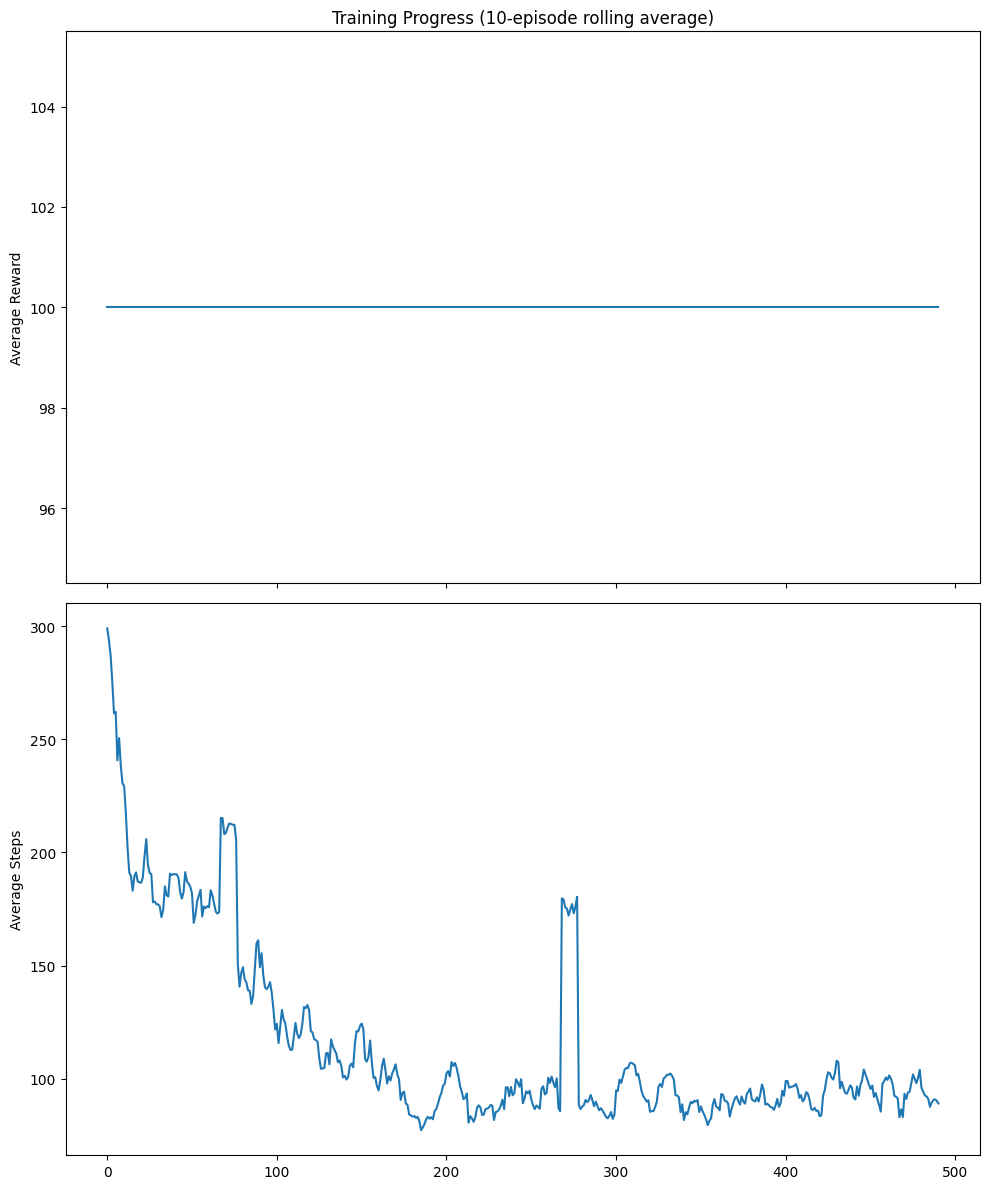

In [13]:
import matplotlib.pyplot as plt

# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

### Testing the Trained Agent

Now let's evaluate our trained agent with exploration turned off to see how well it performs on unseen seeds:

In [14]:
# Turn off exploration for evaluation
agent.exploration_rate = 0

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = agent.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=74, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 2: Steps=74, Reward=100.0, Position=[15 30], Goal reached=True
Test Episode 3: Steps=128, Reward=100.0, Position=[17 31], Goal reached=True
Test Episode 4: Steps=93, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 5: Steps=102, Reward=100.0, Position=[17 30], Goal reached=True


### Visualizing Your Agent's Behavior

While training metrics provide quantitative insights, actually seeing your agent navigate through the environment can reveal critical information about its behavior and strategy.

#### Using evaluate_agent.ipynb for Visualization

The `evaluate_agent.ipynb` notebook provides powerful visualization tools that let you see:
- Complete trajectories across different initial windfields
- How your agent responds to wind conditions
- Frame-by-frame animations of navigation decisions

To use these visualizations, you'll need to save your agent in the proper format first, which we'll do in the next section. Once saved, you can:

1. Open `evaluate_agent.ipynb`
2. Set `AGENT_PATH` to your saved agent file
3. Run the evaluation cells to generate visualizations

These visual insights can help you identify patterns, diagnose issues, and refine your agent's strategy in ways that metrics alone cannot reveal.

## Saving Your Agent for Submission

Now let's save our trained agent as a Python file that can be used for evaluation and submission. This step is crucial for three key reasons:

1. **Visualization and Testing**: Saving allows you to use the `evaluate_agent.ipynb` notebook to visualize trajectories and test performance across different scenarios.

2. **Validation and Evaluation**: The saved agent can be validated with `validate_agent.ipynb` and thoroughly evaluated using different seeds and initial windfields with `evaluate_agent.ipynb`. These notebooks provide important metrics and visualizations to understand your agent's performance.

3. **Submission Format**: Any agent submitted to the evaluator **must** be in this format - a single standalone Python (.py) file with a class that inherits from `BaseAgent` and implements all required methods. This is the official submission format for the challenge.

For Q-learning agents like ours, we've created a utility function `save_qlearning_agent()` in `src/utils/agent_utils.py` that handles the process of saving the agent with all its learned parameters. This creates a standalone Python file ready for submission.

This utility function:
1. Extracts the Q-table from your trained agent
2. Creates a new Python file with a clean agent implementation
3. Embeds the learned Q-values directly in the code
4. Includes all the necessary methods (act, reset, seed, etc.)

In [19]:
sarsa_agent = agent

AttributeError: 'ExpectedSARSALambdaSmartAgent' object has no attribute '__name__'

In [ ]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sarsa_agent,
    output_path=f"../src/agents/{name}_trained.py"
)

Agent saved to ../src/agents/sarsa_improved_trained.py
The file contains 2946 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb


### Extending the Utility for Your Own Agents

If you implement different types of agents (such as DQN, SARSA, or custom algorithms), you may need to create similar utility functions. Some tips:

1. Make sure your save function preserves all necessary parameters and learned values
2. Store them in a way that doesn't require additional files (embedded in the code)
3. Ensure the saved agent includes all required methods from the BaseAgent interface

When extending `save_qlearning_agent()` for different Q-learning variants, you might need to:
- Update the state discretization logic
- Change how parameters are stored and initialized
- Modify the act() method's logic for your specific algorithm

### Agent Types and Saving Strategies

**For Rule-Based Agents:**
- Since rule-based agents don't have learned parameters, you can simply ensure your agent class follows the `BaseAgent` interface
- Implement all required methods: `__init__()`, `act(observation)`, `reset()`, and `seed(seed)`
- These are typically the simplest to save as the agent's logic is entirely defined in the code

**For Deep Learning-Based Agents:**
- Include the model architecture definition directly in your Python file
- Convert model weights to numpy arrays and include them in your code
- Add functions to rebuild the model from these arrays

### Key Requirements for Any Submission File

Regardless of your agent type, ensure your submission file:
1. **Contains everything**: All code, parameters, and data needed to run the agent
2. **Is a single file**: No external dependencies beyond standard libraries
3. **Follows the interface**: Properly inherits from `BaseAgent` and implements all required methods
4. **Requires no arguments**: The agent must initialize without any required arguments
5. **Is deterministic**: For a given seed, the agent should behave identically each time

## Important Note on Import Paths

When creating agent files for submission, make sure to use the correct import paths:
- **Use**: `from agents.base_agent import BaseAgent`
- **Not**: `from src.agents.base_agent import BaseAgent`

This is because the validation and evaluation scripts run from within the `src` directory, so imports should be relative to that location. Our utility function `save_qlearning_agent` already handles this for you.

## Automating Agent Training and Evaluation

The approach we've taken here is interactive and educational, but for serious agent development, you'll likely want to automate the training process. Here's where you could expand:

```python
# Your training script could look something like this:
def train_agent(agent, initial_windfields, num_episodes, save_path):
    # Setup training parameters
    # ...
    
    # Train on multiple initial windfields
    for initial_windfield_name, initial_windfield in initial_windfields.items():
        # Train agent on this initial_windfields
        # ...
        
    # Save the trained agent
    # ...
    
    return training_metrics
```

Creating a command-line interface for training and evaluation would allow you to:
1. Train agents with different hyperparameters
2. Evaluate on multiple initial_windfields 
3. Create systematic experiments

This is left as an exercise for you to implement based on your specific approach.

## Conclusion and Next Steps

In this notebook, we've covered:

1. **Agent Requirements**: Understanding the BaseAgent interface 
2. **The Naive Agent**: Examining a simple rule-based agent 
3. **Simplified Q-Learning Agent**: Implementing and training a basic RL agent that uses only local information (position, velocity, and local wind)

### Next Steps for Developing Your Own Agent

Now it's your turn to develop your own agent. Here are some suggestions:

1. **Enhance the Q-Learning Agent**:
   - Extend the state representation to incorporate the full wind field (not just local wind)
   - This would allow the agent to anticipate wind changes and plan better routes
   - Hint: Modify the `discretize_state` method to extract and process relevant features from the flattened wind field

2. **Algorithmic Improvements**:
   - Implement function approximation to handle continuous state spaces better
   - Explore other RL algorithms like SARSA, Expected SARSA, or Deep Q-Networks
   - Experiment with different exploration strategies that adapt over time

3. **Physics-Based Approaches**:
   - Leverage your understanding of sailing physics (from challenge_walkthrough notebook)
   - Implement rule-based algorithms or path planning (A*, etc.) that take advantage of domain knowledge
   - Create hybrid approaches that combine RL with domain-specific rules
   
### Validating and Evaluating Your Agent

After you've developed your agent, the next steps are to:

1. **Validate your agent** using the `validate_agent.ipynb` notebook or command-line tool
2. **Evaluate your agent** using the `evaluate_agent.ipynb` notebook

Remember that agents combining multiple techniques often perform best - consider how you might blend RL with domain knowledge of sailing physics for optimal results!

Good luck with the Sailing Challenge!